In [15]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space, extract_segments_aligned, autocorr_with_interpolation
from utils.piv_utils import plot_bbox

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [16]:
csv_fp = "./data/csvs/leech-and-swim_082024.csv"
df = pd.read_csv(csv_fp)
df["filename"] = [os.path.splitext(exp)[0] for exp in df.exp.to_list()]
df

,exp,path,mask_path,lense,swim-start,swim-use,status,filename
0,2024_0322_170346_054_trimmed.mp4,"""./data/videos/feature-extraction/""",./data/seg_masks,Dhigh,25.0,1.0,leeching-before,2024_0322_170346_054_trimmed
1,2024_0201_152845_091_10sec.mov,./data/videos/feature-extraction,./data/seg_masks,Dmid,12.0,1.0,leeching-before,2024_0201_152845_091_10sec
2,2024_0430_200515_048.MP4,./data/videos/leeching/philodina/ori_videos,./data/videos/leeching/philodina/seg_masks,Dlow,33.0,5.0,leeching-before,2024_0430_200515_048
3,2024_0502_193145_115.MP4,./data/videos/leeching/philodina/ori_videos,./data/videos/leeching/philodina/seg_masks,Dlow,26.0,2.0,leeching-before,2024_0502_193145_115
4,2024_0227_184332_046.MP4,./data/videos/birdbath,NaN,Dmid,NaN,NaN,ToDO!,2024_0227_184332_046


In [17]:
fn = df.loc[1, "filename"]
mpp = 1/0.4
print(mpp)
fps=24
mask_fp = os.path.join(df.loc[1, "mask_path"], fn+"_masks")
mask_fps = sorted([os.path.join(mask_fp, m) for m in os.listdir(mask_fp) if m.endswith("png")])
contour_list = get_contours_from_segmasks(mask_fps)
df_stats = get_contour_stats(contour_list)
df_stats["frame"] = df_stats.index.values
df_stats["time"] = df_stats["frame"] / fps 
df_stats

2.5


,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,frame,time
0,377.0,300.0,24380.5,65520.0,314.0,846.933108,0.660317,147.415833,NaN,0,0.000000
1,377.0,311.0,25070.5,68340.0,339.0,873.560527,0.591176,151.259476,11.000000,1,0.041667
2,372.0,328.0,25980.0,70688.0,375.0,929.518895,0.500000,155.096329,17.720045,2,0.083333
3,368.0,344.0,26381.5,71779.0,400.0,965.276253,0.446384,157.793167,16.492423,3,0.125000
4,373.0,356.0,27363.5,79130.0,409.0,997.560524,0.470732,157.030518,13.000000,4,0.166667
...,...,...,...,...,...,...,...,...,...,...,...
310,985.0,708.0,32643.0,61884.0,381.0,977.327989,2.358025,78.798332,53.600373,310,12.916667
311,1041.0,699.0,32262.5,61560.0,379.0,965.227483,2.345679,78.405426,56.718604,311,12.958333
312,1104.0,688.0,32855.0,63336.0,376.0,967.327988,2.244048,77.543053,63.953108,312,13.000000
313,1169.0,677.0,33002.0,63126.0,377.0,967.813270,2.263473,77.958374,65.924199,313,13.041667


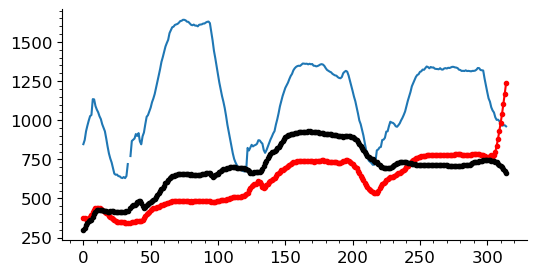

In [18]:
fig, ax = plt.subplots()
plt.plot(df_stats.perimeter)
plt.plot(df_stats.centroid_x, "-r.")
plt.plot(df_stats.centroid_y, "-k.")
plt.minorticks_on()

In [19]:
data = {"dist-sec" : [],
        "mum-stride" : []}

dist: 538.706754888372 187.82055261064792
dur: 7.916666666666666 0.375
dist[µm]/sec: 68.0 500.9
3 strides; µm / stride: 179.6


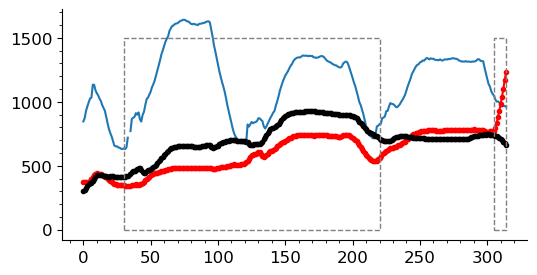

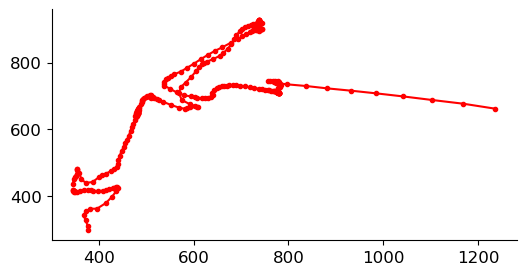

In [20]:
leech_idx = [30, 220]
swim_idx = [305, 314]

fig, ax = plt.subplots()
plt.plot(df_stats.perimeter)
plt.plot(df_stats.centroid_x, "-r.")
plt.plot(df_stats.centroid_y, "-k.")
plt.minorticks_on()

plot_bbox(leech_idx + [0, 1500], ax=ax, c="gray")
plot_bbox(swim_idx + [0, 1500], ax=ax, c="gray")

fig, ax = plt.subplots()
plt.plot(df_stats.centroid_x, df_stats.centroid_y, "-r.")

leech_dist = np.nansum(df_stats.loc[df_stats["frame"].between(leech_idx[0], leech_idx[1]), "centroid_dist"]) / mpp
swim_dist = np.nansum(df_stats.loc[df_stats["frame"].between(swim_idx[0], swim_idx[1]), "centroid_dist"]) / mpp
leech_duration = df_stats.loc[leech_idx[1], "time"] - df_stats.loc[leech_idx[0], "time"]
swim_duration = df_stats.loc[swim_idx[1], "time"] - df_stats.loc[swim_idx[0], "time"]

print("dist:",leech_dist, swim_dist)
print("dur:",leech_duration, swim_duration)
print("dist[µm]/sec:", round(leech_dist/leech_duration,1), round(swim_dist / swim_duration,1))
print("3 strides; µm / stride:", round(leech_dist / 3,1))

# pretty sure I'm missing a factor of two HERE!
# mostly likly the 24 to 60 fps difference. Maybe have to normalize that somewhere
data["dist-sec"].append([round(leech_dist/leech_duration,1)*2, round(swim_dist / swim_duration,1)*2])
data["mum-stride"].append(round(leech_dist / 3,1)*2)

In [21]:
# Save figures
results_path = "./data/results/leeching/"

df_stats = pd.read_csv(os.path.join(results_path, df.loc[2, "filename"], "df_stats.csv"))
df_points = pd.read_csv(os.path.join(results_path, df.loc[2, "filename"], "df_points.csv"))
df_stats["frame"] = df_stats.index.values
fps=60
df_stats["time"] = df_stats["frame"] / fps 
df_stats

,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,frame,time
0,243.0,452.0,3532.5,6000.0,0.588750,349.781744,3.750000,93.055847,NaN,0,0.000000
1,243.0,453.0,3557.0,6232.0,0.570764,355.823375,3.707317,90.053528,1.0,1,0.016667
2,243.0,454.0,3609.0,6384.0,0.565320,354.509666,3.619048,91.849823,1.0,2,0.033333
3,243.0,454.0,3585.0,6314.0,0.567786,359.338093,3.756098,90.995590,0.0,3,0.050000
4,243.0,454.0,3596.0,6314.0,0.569528,359.338093,3.756098,91.387024,0.0,4,0.066667
...,...,...,...,...,...,...,...,...,...,...,...
2349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2349,39.150000
2350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2350,39.166667
2351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2351,39.183333
2352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2352,39.200000


dist: 1603.4754163424311 2703.6330147185486
dur: 15.833333333333332 3.3333333333333357
dist[µm]/sec: 101.3 811.1
4 strides; µm / stride: 400.8688540856078


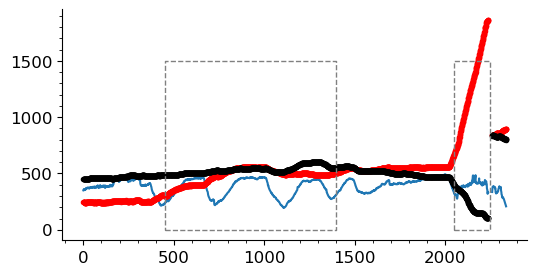

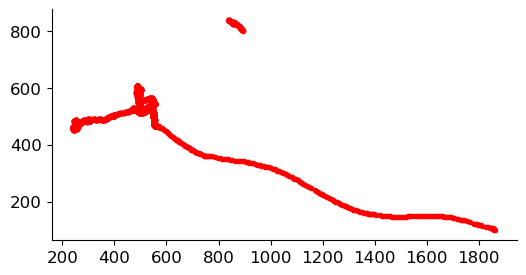

In [22]:
mpp = 0.47 # microns_per_pixel for Dlow

leech_idx = [450, 1400]
swim_idx = [2050, 2250]

fig, ax = plt.subplots()
plt.plot(df_stats.perimeter)
plt.plot(df_stats.centroid_x, "-r.")
plt.plot(df_stats.centroid_y, "-k.")
plt.minorticks_on()

plot_bbox(leech_idx + [0, 1500], ax=ax, c="gray")
plot_bbox(swim_idx + [0, 1500], ax=ax, c="gray")

fig, ax = plt.subplots()
plt.plot(df_stats.centroid_x, df_stats.centroid_y, "-r.")

leech_dist = np.nansum(df_stats.loc[df_stats["frame"].between(leech_idx[0], leech_idx[1]), "centroid_dist"]) / mpp
swim_dist = np.nansum(df_stats.loc[df_stats["frame"].between(swim_idx[0], swim_idx[1]), "centroid_dist"]) / mpp
leech_duration = df_stats.loc[leech_idx[1], "time"] - df_stats.loc[leech_idx[0], "time"]
swim_duration = df_stats.loc[swim_idx[1], "time"] - df_stats.loc[swim_idx[0], "time"]


print("dist:",leech_dist, swim_dist)
print("dur:",leech_duration, swim_duration)
print("dist[µm]/sec:", round(leech_dist/leech_duration,1), round(swim_dist / swim_duration,1))
print("4 strides; µm / stride:", leech_dist / 4)

data["dist-sec"].append([round(leech_dist/leech_duration,1), round(swim_dist / swim_duration,1)])
data["mum-stride"].append(round(leech_dist / 4,1))

In [23]:

df_stats = pd.read_csv(os.path.join(results_path, df.loc[3, "filename"], "df_stats.csv"))
df_points = pd.read_csv(os.path.join(results_path, df.loc[3, "filename"], "df_points.csv"))
df_stats["frame"] = df_stats.index.values
fps=60
df_stats["time"] = df_stats["frame"] / fps 
df_stats

,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,frame,time
0,1358.0,272.0,6171.0,10830.0,0.569806,328.475177,0.833333,38.416416,NaN,0,0.000000
1,1359.0,273.0,6167.0,10944.0,0.563505,328.132030,0.842105,38.523056,1.414214,1,0.016667
2,1359.0,274.0,6160.5,10925.0,0.563890,328.374672,0.826087,37.570786,1.000000,2,0.033333
3,1358.0,274.0,6149.5,10998.0,0.559147,326.031527,0.803419,36.610897,1.000000,3,0.050000
4,1357.0,276.0,6093.5,10881.0,0.560013,325.203100,0.794872,36.488388,2.236068,4,0.066667
...,...,...,...,...,...,...,...,...,...,...,...
1743,318.0,47.0,5511.5,10920.0,0.504716,361.119838,1.794872,67.277893,0.000000,1743,29.050000
1744,318.0,48.0,5612.5,11200.0,0.501116,364.776692,1.750000,66.314819,1.000000,1744,29.066667
1745,317.0,49.0,5783.5,11985.0,0.482562,371.261973,1.658824,65.039291,1.414214,1745,29.083333
1746,317.0,48.0,5709.0,11844.0,0.482016,370.676187,1.678571,64.875038,1.000000,1746,29.100000


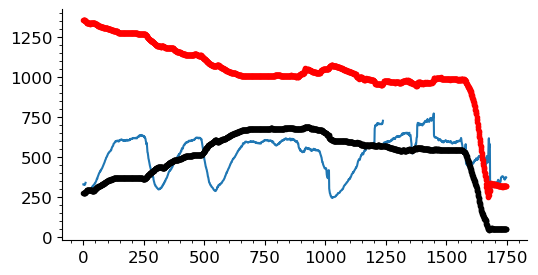

In [24]:
fig, ax = plt.subplots()
plt.plot(df_stats.perimeter)
plt.plot(df_stats.centroid_x, "-r.")
plt.plot(df_stats.centroid_y, "-k.")
plt.minorticks_on()

dist: 878.1710652464262 1453.5285927420655
dur: 4.999999999999999 1.1666666666666679
dist[µm]/sec: 175.6 1245.9
2 strides; µm / stride: 439.0855326232131


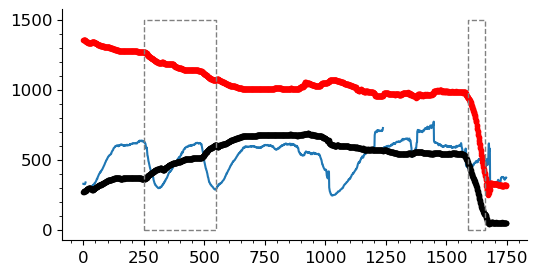

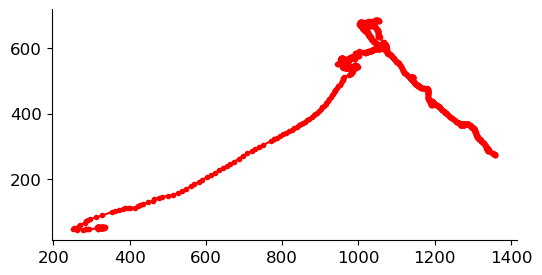

In [25]:
mpp = 0.47 # microns_per_pixel for Dlow

leech_idx = [250, 550]  # have to limit this because theres stage movement inbetween!!!
swim_idx = [1590, 1660]

fig, ax = plt.subplots()
plt.plot(df_stats.perimeter)
plt.plot(df_stats.centroid_x, "-r.")
plt.plot(df_stats.centroid_y, "-k.")
plt.minorticks_on()

plot_bbox(leech_idx + [0, 1500], ax=ax, c="gray")
plot_bbox(swim_idx + [0, 1500], ax=ax, c="gray")

fig, ax = plt.subplots()
plt.plot(df_stats.centroid_x, df_stats.centroid_y, "-r.")

leech_dist = np.nansum(df_stats.loc[df_stats["frame"].between(leech_idx[0], leech_idx[1]), "centroid_dist"]) / mpp
swim_dist = np.nansum(df_stats.loc[df_stats["frame"].between(swim_idx[0], swim_idx[1]), "centroid_dist"]) / mpp
leech_duration = df_stats.loc[leech_idx[1], "time"] - df_stats.loc[leech_idx[0], "time"]
swim_duration = df_stats.loc[swim_idx[1], "time"] - df_stats.loc[swim_idx[0], "time"]


print("dist:",leech_dist, swim_dist)
print("dur:",leech_duration, swim_duration)
print("dist[µm]/sec:", round(leech_dist/leech_duration,1), round(swim_dist / swim_duration,1))
print("2 strides; µm / stride:", leech_dist / 2)

data["dist-sec"].append([round(leech_dist/leech_duration,1), round(swim_dist / swim_duration,1)])
data["mum-stride"].append(round(leech_dist / 2,1))

In [26]:
data["mum-stride"]

[359.2, 400.9, 439.1]

In [33]:
data["dist-sec"]
np.mean(d_, axis=0)

array([ 137.63333333, 1019.6       ])

In [38]:
d_[:,1] / d_[:,0]

array([7.36617647, 8.00691017, 7.09510251])

In [35]:
d_ = np.array(data["dist-sec"])
print("leeching: ", round(np.mean(d_, axis=0)[0],1), "±", round(np.std(d_, axis=0)[0],1))
print("swim: ", round(np.mean(d_, axis=0)[1],1), "±", round(np.std(d_, axis=0)[1],1))

leeching:  137.6 ± 30.4
swim:  1019.6 ± 178.0


In [36]:
1019.6 / 137.6

7.409883720930233